Notebook này được xây dựng trên kaggle. Để chạy trực tiếp, truy cập https://www.kaggle.com/freymiggen/anlab-bike-classifier

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import optim
import torchvision
from torchvision import transforms,models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import feature_extraction
from torch.utils.data import DataLoader,Dataset

In [51]:
DEVICE=torch.device('cuda')

# 1. Explore 2 Datasets that we will use for training

### 1.1. Explore 2 classes from ImageNet 

In [52]:
motor_dir='/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n03791053'
bicycle_dir='/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n03792782'
motor=[os.path.join(motor_dir,name) for name in os.listdir(motor_dir)]
bicycle=[os.path.join(bicycle_dir,name) for name in os.listdir(bicycle_dir)]

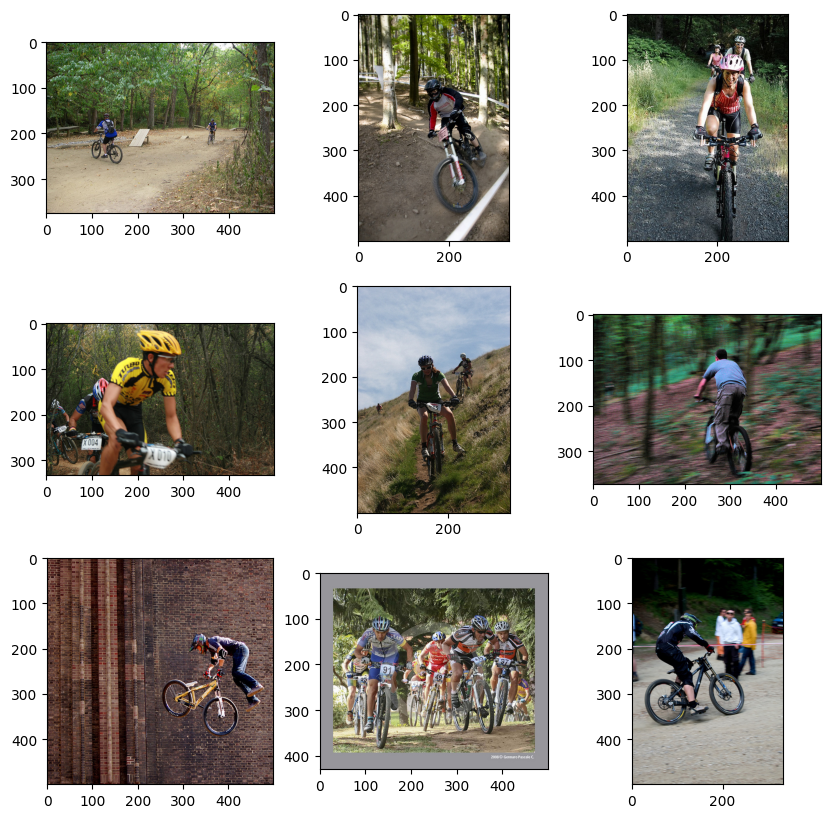

In [53]:
indices=np.random.randint(1,100,9)
fig = plt.figure(figsize=(10,10))
for i in range(len(indices)):
    img=plt.imread(bicycle[indices[i]])
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)

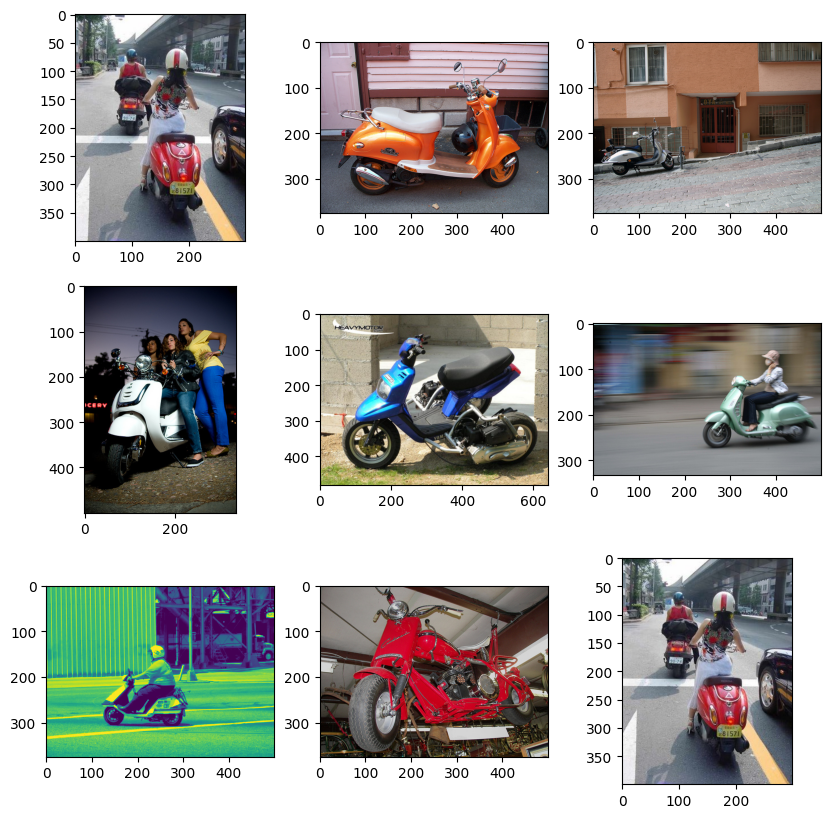

In [55]:
indices=np.random.randint(1,100,9)
fig = plt.figure(figsize=(10,10))
for i in range(len(indices)):
    img=plt.imread(motor[indices[i]])
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)

## 2.1. Explore HanoiBike dataset

In [6]:
motor_dir='/kaggle/input/hanoi-bike/BIKE/train/motorbike'
bicycle_dir='/kaggle/input/hanoi-bike/BIKE/train/bicycle'
motor=[os.path.join(motor_dir,name) for name in os.listdir(motor_dir)]
bicycle=[os.path.join(bicycle_dir,name) for name in os.listdir(bicycle_dir)]

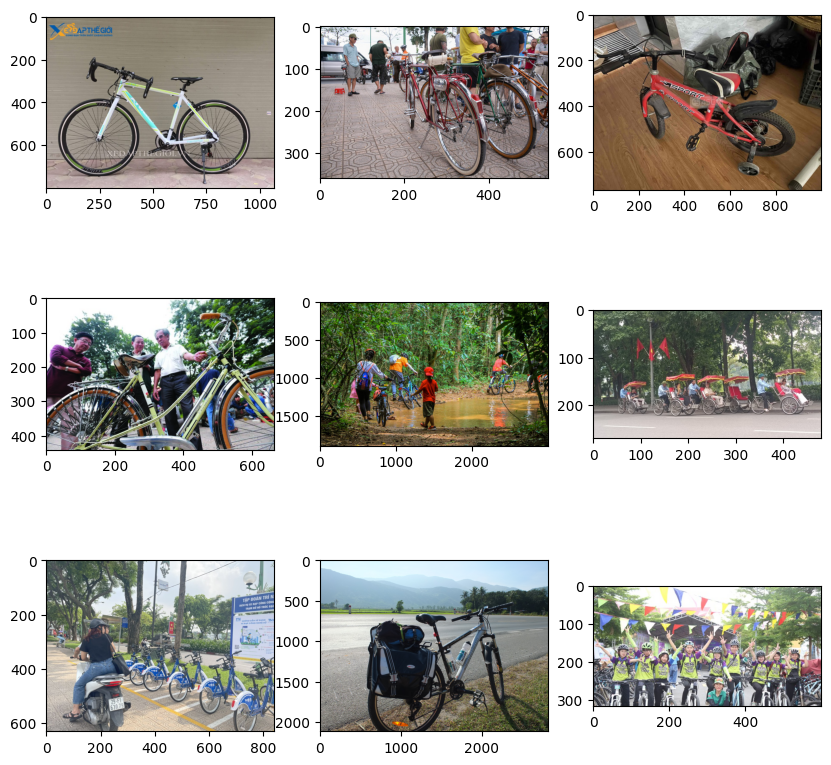

In [8]:
indices=np.random.randint(1,100,9)
fig = plt.figure(figsize=(10,10))
for i in range(len(indices)):
    img=plt.imread(bicycle[indices[i]])
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)

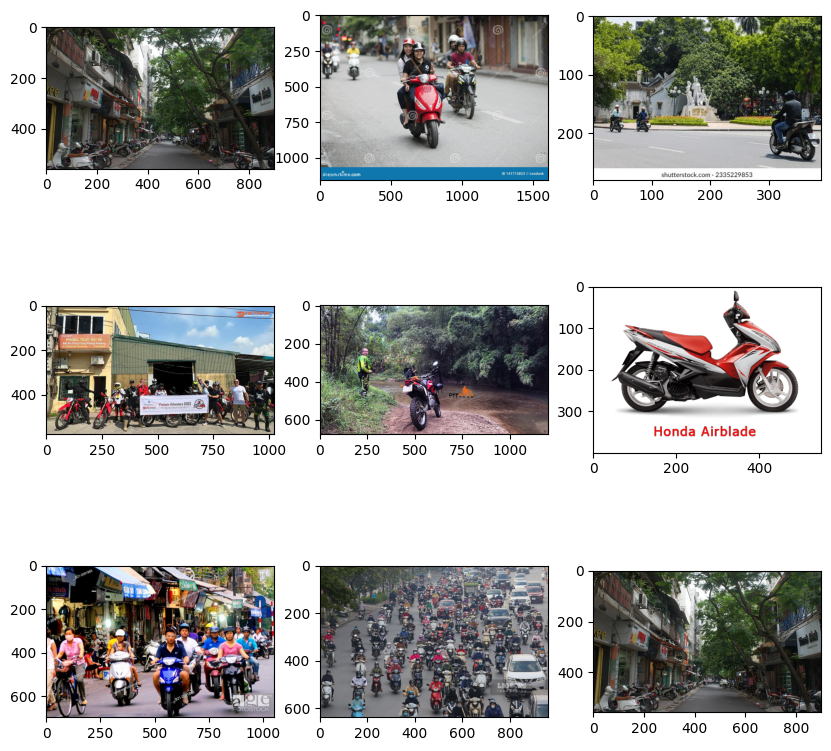

In [10]:
indices=np.random.randint(1,100,9)
fig = plt.figure(figsize=(10,10))
for i in range(len(indices)):
    img=plt.imread(motor[indices[i]])
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)

# 2. Build model and DataLoader

In [3]:
class ImagenetDataset(torch.utils.data.Dataset):
    """
    A tiny version of PASCAL VOC 2007 Detection dataset that includes images and
    annotations with small images and no difficult boxes.
    """

    def __init__(
        self,
        dataset_dir: str,
        motor_fol:str,
        cycle_fol:str,
        image_size: int = 224,
        repeat:int=5
    ):
        """
        Args:
            
            image_size: Size of imges in the batch. The shorter edge of images
                will be resized to this size, followed by a center crop. 
        """
        super().__init__()
        self.image_size = image_size
        self.classes=['motorbike','bicyle']
        
        # Load instances from JSON file:
        motor_dir=os.path.join(dataset_dir,motor_fol)
        bicycle_dir=os.path.join(dataset_dir,cycle_fol)
        
        motor=[os.path.join(motor_dir,file) for file in os.listdir(motor_dir)]*repeat
        bicycle=[os.path.join(bicycle_dir,file) for file in os.listdir(bicycle_dir)]*repeat
        instances=list()
        for i in range(len(motor)):
            temp={'name':motor[i],'label':1}
            instances.append(temp)
            
        for i in range(len(bicycle)):
            temp={'name':bicycle[i],'label':0}
            instances.append(temp)
            
        self.instances=instances
        self.dataset_dir = dataset_dir

        # Define a transformation function for image: Resize the shorter image
        # edge then take a center crop (optional) and normalize.
        _transforms = [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
             transforms.Normalize(
               mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
            transforms.RandomRotation((0.1,0.5)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)
        ]
      
        self.image_transform = transforms.Compose(_transforms)
    def __len__(self):
            return len(self.instances)

    def __getitem__(self, index: int):
        # PIL image and dictionary of annotations.
        instance=self.instances[index]
        image_path, label=instance['name'],instance['label']

        image_path = os.path.join(self.dataset_dir, image_path)
        image = Image.open(image_path).convert("RGB")

        # Transform input image to CHW tensor.
        image = self.image_transform(image)

        # Return image path because it is needed for evaluation.
        return image_path, image, label

In [4]:
class Classifier(nn.Module):
    def __init__(self,hidden_unit=128,num_class=1,verbose=True,image_size=224,):
        super().__init__()
        cnn = models.regnet_x_400mf(weights='DEFAULT')
        self.backbone = feature_extraction.create_feature_extractor(
        cnn,
        return_nodes={
            
            "avgpool":'avgpool'
                },
        )
        for child in self.backbone.parameters():
            child.requires_grad=False
        # image_size
        
        dummy=torch.randn(2,3,image_size,image_size)
        out_shape=self.backbone(dummy)['avgpool'].shape
        if verbose:
            print('output shape of backbone: ',out_shape)
            
        self.linear=nn.Sequential(nn.Linear(out_shape[1],hidden_unit,bias=True),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.5))
        self.cls=nn.Linear(hidden_unit,num_class,bias=True)
    def unfreeze(self):
        for child in self.backbone.parameters():
            child.requires_grad=True
    def forward(self,images):
        x=self.backbone(images)['avgpool']       
        x=x.view(images.shape[0],-1)
        x=self.linear(x)
        x=self.cls(x)                 
        x=F.sigmoid(x)
        return x.squeeze(dim=-1)

In [5]:
trainset=ImagenetDataset('/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train',
                        motor_fol='n03791053',
                        cycle_fol='n03792782')

In [6]:
train_loader=DataLoader(trainset,shuffle=True,batch_size=128,pin_memory=True)

In [7]:
model=Classifier()

Downloading: "https://download.pytorch.org/models/regnet_x_400mf-62229a5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-62229a5f.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 101MB/s] 


output shape of backbone:  torch.Size([2, 400, 1, 1])


In [8]:
model.to(DEVICE)

Classifier(
  (backbone): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Module(
      (block1): Module(
        (block1-0): Module(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): Module(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),

# 3. Train on Imagenet

In [9]:
optimizer=torch.optim.Adam([{'params':model.linear.parameters(),'lr':1e-3},
                           {'params':model.cls.parameters(),'lr':1e-3}],
                            lr=1e-6)
loss_fn=torch.nn.BCELoss(reduction='mean')

In [10]:
def accuracy(pred,target,sigmoid=False):
    # if pred>0.5 =>set to 1
    if sigmoid:
        pred=F.sigmoid(pred)
    pred[pred>0.5]=1.
    pred[pred<=0.5]=0.
    acc=(pred==target).to(float)
    return torch.mean(acc)

In [11]:
def train_one_epoch(model,data_loader,optimizer,loss_fn,DEVICE=torch.device('cuda')):
    running_loss = 0.0
    running_acc= 0.0
    for i, data in enumerate(data_loader):
        _, inputs, labels = data
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass, track history if using gradients for model analysis
        outputs = model(inputs.to(DEVICE))
        loss = loss_fn(outputs.to(float), labels.to(float).to(DEVICE))
        acc=accuracy(outputs.to(float), labels.to(float).to(DEVICE))
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        running_acc+=acc
        if i % 20 == 19:  # Print every 20 mini-batches
            print('loss: %.3f' % (running_loss / 20))
            print(' acc: %.3f' % (running_acc / 20))
            running_loss = 0.0
            running_acc=0.0
                

In [14]:
EPOCH=0
for epoch in range(10):  # Adjust number of epochs
    print(f"EPOCH: {EPOCH+epoch+1}")
    train_one_epoch(model,train_loader,optimizer,loss_fn)

EPOCH: 6
loss: 0.046
 acc: 0.983
loss: 0.050
 acc: 0.980
loss: 0.050
 acc: 0.982
loss: 0.050
 acc: 0.980
loss: 0.055
 acc: 0.978
EPOCH: 7
loss: 0.043
 acc: 0.984
loss: 0.051
 acc: 0.982
loss: 0.038
 acc: 0.986
loss: 0.040
 acc: 0.987
loss: 0.033
 acc: 0.988
EPOCH: 8
loss: 0.038
 acc: 0.988
loss: 0.040
 acc: 0.986
loss: 0.034
 acc: 0.988
loss: 0.036
 acc: 0.988
loss: 0.034
 acc: 0.989
EPOCH: 9
loss: 0.032
 acc: 0.988
loss: 0.033
 acc: 0.988
loss: 0.047
 acc: 0.982
loss: 0.038
 acc: 0.986
loss: 0.046
 acc: 0.981
EPOCH: 10
loss: 0.039
 acc: 0.984
loss: 0.031
 acc: 0.989
loss: 0.031
 acc: 0.991
loss: 0.034
 acc: 0.988
loss: 0.027
 acc: 0.991


# 4. Finetune with Hanoi dataset

In [29]:
hanoi_trainset=ImagenetDataset('/kaggle/input/hanoi-bike/BIKE/train',
                        motor_fol='motorbike',
                        cycle_fol='bicycle')
hanoi_valset=ImagenetDataset('/kaggle/input/hanoi-bike/BIKE/val',
                        motor_fol='motorbike',
                        cycle_fol='bicycle',repeat=1)

In [30]:
hanoi_trainloader=DataLoader(hanoi_trainset,shuffle=True,batch_size=128,pin_memory=True)
hanoi_valloader=DataLoader(hanoi_valset,shuffle=True,batch_size=32,pin_memory=True)

In [23]:
epoch_number=0
EPOCHS=10
best_vloss = 10
for epoch in range(epoch_number,EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    train_one_epoch(model,hanoi_trainloader,optimizer,loss_fn)
    running_vloss = 0.0
    running_vacc=0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(hanoi_valloader):
            vinputs=vdata[1].to(DEVICE)
            vlabels=vdata[2].to(DEVICE)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.to(float), vlabels.to(float))
            running_vloss += vloss
            vacc=accuracy(voutputs.to(float), vlabels.to(float))
            running_vacc += vacc

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    
    print('VALID LOSS: %.3f' % (avg_vloss ))
    print('VALID ACC: %.3f' % (avg_vacc ))
    print('\n')
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '/kaggle/working/model_finetune{}.pt'.format(epoch_number+1)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.463
 acc: 0.824
loss: 0.328
 acc: 0.855
VALID LOSS: 0.295
VALID ACC: 0.881


EPOCH 2:
loss: 0.273
 acc: 0.886
loss: 0.259
 acc: 0.894
VALID LOSS: 0.246
VALID ACC: 0.919


EPOCH 3:
loss: 0.235
 acc: 0.907
loss: 0.220
 acc: 0.916
VALID LOSS: 0.304
VALID ACC: 0.844


EPOCH 4:
loss: 0.225
 acc: 0.911
loss: 0.213
 acc: 0.915
VALID LOSS: 0.253
VALID ACC: 0.900


EPOCH 5:
loss: 0.197
 acc: 0.924
loss: 0.195
 acc: 0.924
VALID LOSS: 0.251
VALID ACC: 0.890


EPOCH 6:
loss: 0.192
 acc: 0.927
loss: 0.185
 acc: 0.921
VALID LOSS: 0.317
VALID ACC: 0.860


EPOCH 7:
loss: 0.182
 acc: 0.930
loss: 0.180
 acc: 0.931
VALID LOSS: 0.248
VALID ACC: 0.885


EPOCH 8:
loss: 0.176
 acc: 0.930
loss: 0.167
 acc: 0.938
VALID LOSS: 0.320
VALID ACC: 0.881


EPOCH 9:
loss: 0.164
 acc: 0.938
loss: 0.168
 acc: 0.934
VALID LOSS: 0.207
VALID ACC: 0.931


EPOCH 10:
loss: 0.161
 acc: 0.944
loss: 0.152
 acc: 0.941
VALID LOSS: 0.154
VALID ACC: 0.946




### Unfreeze the model and let it train for another 70 epochs.

In [24]:
model.unfreeze()

In [25]:
optimizer=torch.optim.Adam([{'params':model.linear.parameters(),'lr':1e-3},
                           {'params':model.cls.parameters(),'lr':1e-3},
                           {'params':model.backbone.parameters(),'lr':1e-6}],
                            )
loss_fn=torch.nn.BCELoss(reduction='mean')

In [38]:
epoch_number=60
EPOCHS=70
# best_vloss = 10
for epoch in range(epoch_number,EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    train_one_epoch(model,hanoi_trainloader,optimizer,loss_fn)
    running_vloss = 0.0
    running_vacc=0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(hanoi_valloader):
            vinputs=vdata[1].to(DEVICE)
            vlabels=vdata[2].to(DEVICE)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.to(float), vlabels.to(float))
            running_vloss += vloss
            vacc=accuracy(voutputs.to(float), vlabels.to(float))
            running_vacc += vacc

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    
    print('VALID LOSS: %.3f' % (avg_vloss ))
    print('VALID ACC: %.3f' % (avg_vacc ))
    print('\n')
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '/kaggle/working/model_{}.pt'.format(epoch_number+1)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 61:


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 0.020
 acc: 0.994
loss: 0.016
 acc: 0.993
VALID LOSS: 0.397
VALID ACC: 0.927


EPOCH 62:
loss: 0.014
 acc: 0.994
loss: 0.020
 acc: 0.995
VALID LOSS: 0.413
VALID ACC: 0.917


EPOCH 63:
loss: 0.018
 acc: 0.995
loss: 0.016
 acc: 0.995
VALID LOSS: 0.877
VALID ACC: 0.944


EPOCH 64:
loss: 0.019
 acc: 0.993
loss: 0.016
 acc: 0.995
VALID LOSS: 0.342
VALID ACC: 0.917


EPOCH 65:
loss: 0.019
 acc: 0.993
loss: 0.017
 acc: 0.994
VALID LOSS: 0.231
VALID ACC: 0.927


EPOCH 66:
loss: 0.014
 acc: 0.995
loss: 0.019
 acc: 0.993
VALID LOSS: 0.228
VALID ACC: 0.938


EPOCH 67:
loss: 0.014
 acc: 0.996
loss: 0.013
 acc: 0.996
VALID LOSS: 0.334
VALID ACC: 0.910


EPOCH 68:
loss: 0.012
 acc: 0.996
loss: 0.016
 acc: 0.993
VALID LOSS: 0.325
VALID ACC: 0.921


EPOCH 69:
loss: 0.021
 acc: 0.992
loss: 0.019
 acc: 0.995
VALID LOSS: 0.278
VALID ACC: 0.919


EPOCH 70:
loss: 0.013
 acc: 0.994
loss: 0.012
 acc: 0.996
VALID LOSS: 0.404
VALID ACC: 0.931




### Evaluate model after 60 epochs of finetuning

In [167]:
model.eval()
testset=DataLoader(hanoi_valset,shuffle=True,batch_size=100,pin_memory=True)
test=iter(testset)
sample=next(test)

In [168]:
pred=model(sample[1].to(DEVICE))
label=sample[2].to(DEVICE).to(torch.float32)


In [169]:
pred[pred>0.5]=1.
pred[pred<=0.5]=0.
match_label=(pred==label).to(torch.int)
print(f'NUMBER OF CORRECT PREDICTION: {torch.sum(match_label)}')

NUMBER OF CORRECT PREDICTION: 94


In [40]:
!cd /kaggle/working

In [131]:
from IPython.display import FileLink
FileLink(r'model_finetune60.pt')

/kaggle/working/model_finetune60.pt

# 3. Test

In [154]:
model.load_state_dict(torch.load('/kaggle/input/classifier-bike/model_finetune60.pt'))
model.to(DEVICE)
model.eval()

Classifier(
  (backbone): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Module(
      (block1): Module(
        (block1-0): Module(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): Module(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),

In [125]:
def test(img_path):
    img=Image.open(img_path).convert('RGB')
    plt.imshow(img)
    img=torchvision.transforms.functional.pil_to_tensor(img).to(torch.float32)/255.0
    img=torchvision.transforms.functional.resize(img,(224,224))
    img=torchvision.transforms.functional.normalize(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img=torch.unsqueeze(img,dim=0)
    pred=model(img.to(DEVICE))
    if pred<0.5:
        print('BICYCLE')
    else:
        print('MOTORBIKE')

tensor([0.0022], device='cuda:0', grad_fn=<SqueezeBackward1>)
BICYCLE


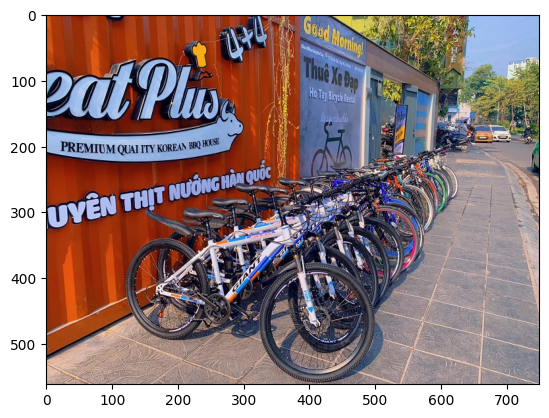

In [130]:
img=test('/kaggle/input/bike-test/test/cycle_2.jpg')